# Traduction anglais-français avec un transformers

## Introduction

Dans cet exemple, nous allons construire un modèle Transformer de séquence à séquence, que nous allons entraîner sur une tâche de traduction automatique de l'anglais vers le français.

Vous apprendrez à :

- Vectoriser le texte à l'aide de la couche Keras `TextVectorization`.
- Implémenter une couche `TransformerEncoder`, une couche `TransformerDecoder`,
et une couche `PositionalEmbedding`.
- Préparez les données pour l'entraînement d'un modèle séquence-séquence.
- Utilisez le modèle entraîné pour générer des traductions de phrases d'entrée jamais vues (séquence à séquence dans le cas d'un modèle à séquence).
phrases d'entrée jamais vues (inférence séquence à séquence).

Le code présenté ici est adapté du livre
[Deep Learning with Python, Second Edition] (https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapitre 11 : Deep learning for text).

Le livre présentait la traduction de l'anglais vers l'espagnole. Nous allons traduire plutôt vers le français pour pouvoir évaluer la performance du modèle plus simplement.

Si vous voulez en savoir plus sur les transformers je vous recommande la lecture de ce livre.

## Importation des packages

In [ ]:
!pip install keras==3.0

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
import keras.ops as ops
from keras.layers import TextVectorization

## Téléchargement des données

Nous travaillerons avec un ensemble de données de traduction de l'anglais vers le français
fourni par [Anki](https://www.manythings.org/anki/).

Nous allons le télécharger :

In [ ]:
text_file = keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent /  "fra.txt"

## Préparation des données

Chaque ligne contient une phrase anglaise et sa phrase française correspondante.

La phrase anglaise est la *séquence source* et la phrase française est la *séquence cible*.

Nous ajoutons le token `"[start]"` au début et le token `"[end]"` à la fin de la phrase française.

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    text_pairs.append((eng, fra))

Voici à quoi ressemblent nos paires de phrases :

In [ ]:
for _ in range(5):
    print(random.choice(text_pairs))

Divisons maintenant les paires de phrases en un ensemble d'entraînement, un ensemble de validation, et un ensemble de test.

In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

Appliquer les indices *num_train_samples* et *num_val_samples* pour séparer le jeu de données.

In [ ]:
train_pairs =  None
val_pairs = None
test_pairs = None

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

Vous devrez obtenir le résultat suivant:

167130 total pairs

116992 training pairs

25069 validation pairs

25069 test pairs

## Vectorisation des données textuelles

Nous utiliserons deux instances de la couche `TextVectorization` pour vectoriser les données textuelles (une pour l'anglais et une pour le français), c'est-à-dire pour transformer les chaînes de caractères originales en séquences d'entiers où chaque entier représente l'index d'un mot dans un vecteur de vocabulaire.

In [ ]:
vocab_size = 15000
sequence_length = 20
batch_size = 64

Utilisez *train_pairs* et séparer les phrases françaises dans *train_fra_texts* et les phrases anglaises dans *train_eng_texts*

In [ ]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]

Initialiser *eng_vectorization* et *fra_vectorization* en utilisant TextVectorization.

N'hésite pas à regarder la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [ ]:
eng_vectorization = None
fra_vectorization = None

Appliquez les *vectorization* au jeu d'entraînement en utilisant la méthode *adapt*.

N'hésite pas à regarder la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [ ]:
None
None

Ensuite, nous formaterons nos ensembles de données.

À chaque étape de l'apprentissage, le modèle cherchera à prédire les mots cibles N+1 (et au-delà) en utilisant la phrase source et les mots cibles 0 à N.

En tant que tel, le jeu de données d'entraînement produira un tuple `(inputs, targets)`, où :

- `inputs` est un dictionnaire avec les clés `encoder_inputs` et `decoder_inputs`. `decoder_inputs` est la phrase source vectorisée et `encoder_inputs` est la phrase cible "jusqu'à présent", c'est-à-dire les mots 0 à N utilisés pour prédire le mot N+1 (et au-delà) dans la phrase cible.
- `target` est la phrase cible décalée d'un pas : elle fournit les mots suivants dans la phrase cible -- ce que le modèle va essayer de prédire.

In [ ]:
def format_dataset(eng, fra):
    eng = eng_vectorization(eng)
    fra = fra_vectorization(fra)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": fra[:, :-1],
        },
        fra[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, fra_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, fra_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Examinons rapidement les formes des séquences (nous avons des lots de 64 paires et toutes les séquences ont une longueur de 20 termes) :

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

## Initialisation du modèle

Notre transformers de séquence à séquence est constitué d'un `TransformerEncoder` et d'un `TransformerDecoder` relié l'un à l'autre. Pour que le modèle tienne compte de l'ordre des mots, nous utilisons également une couche `PositionalEmbedding`.

Prenez exemple sur ce schéma :

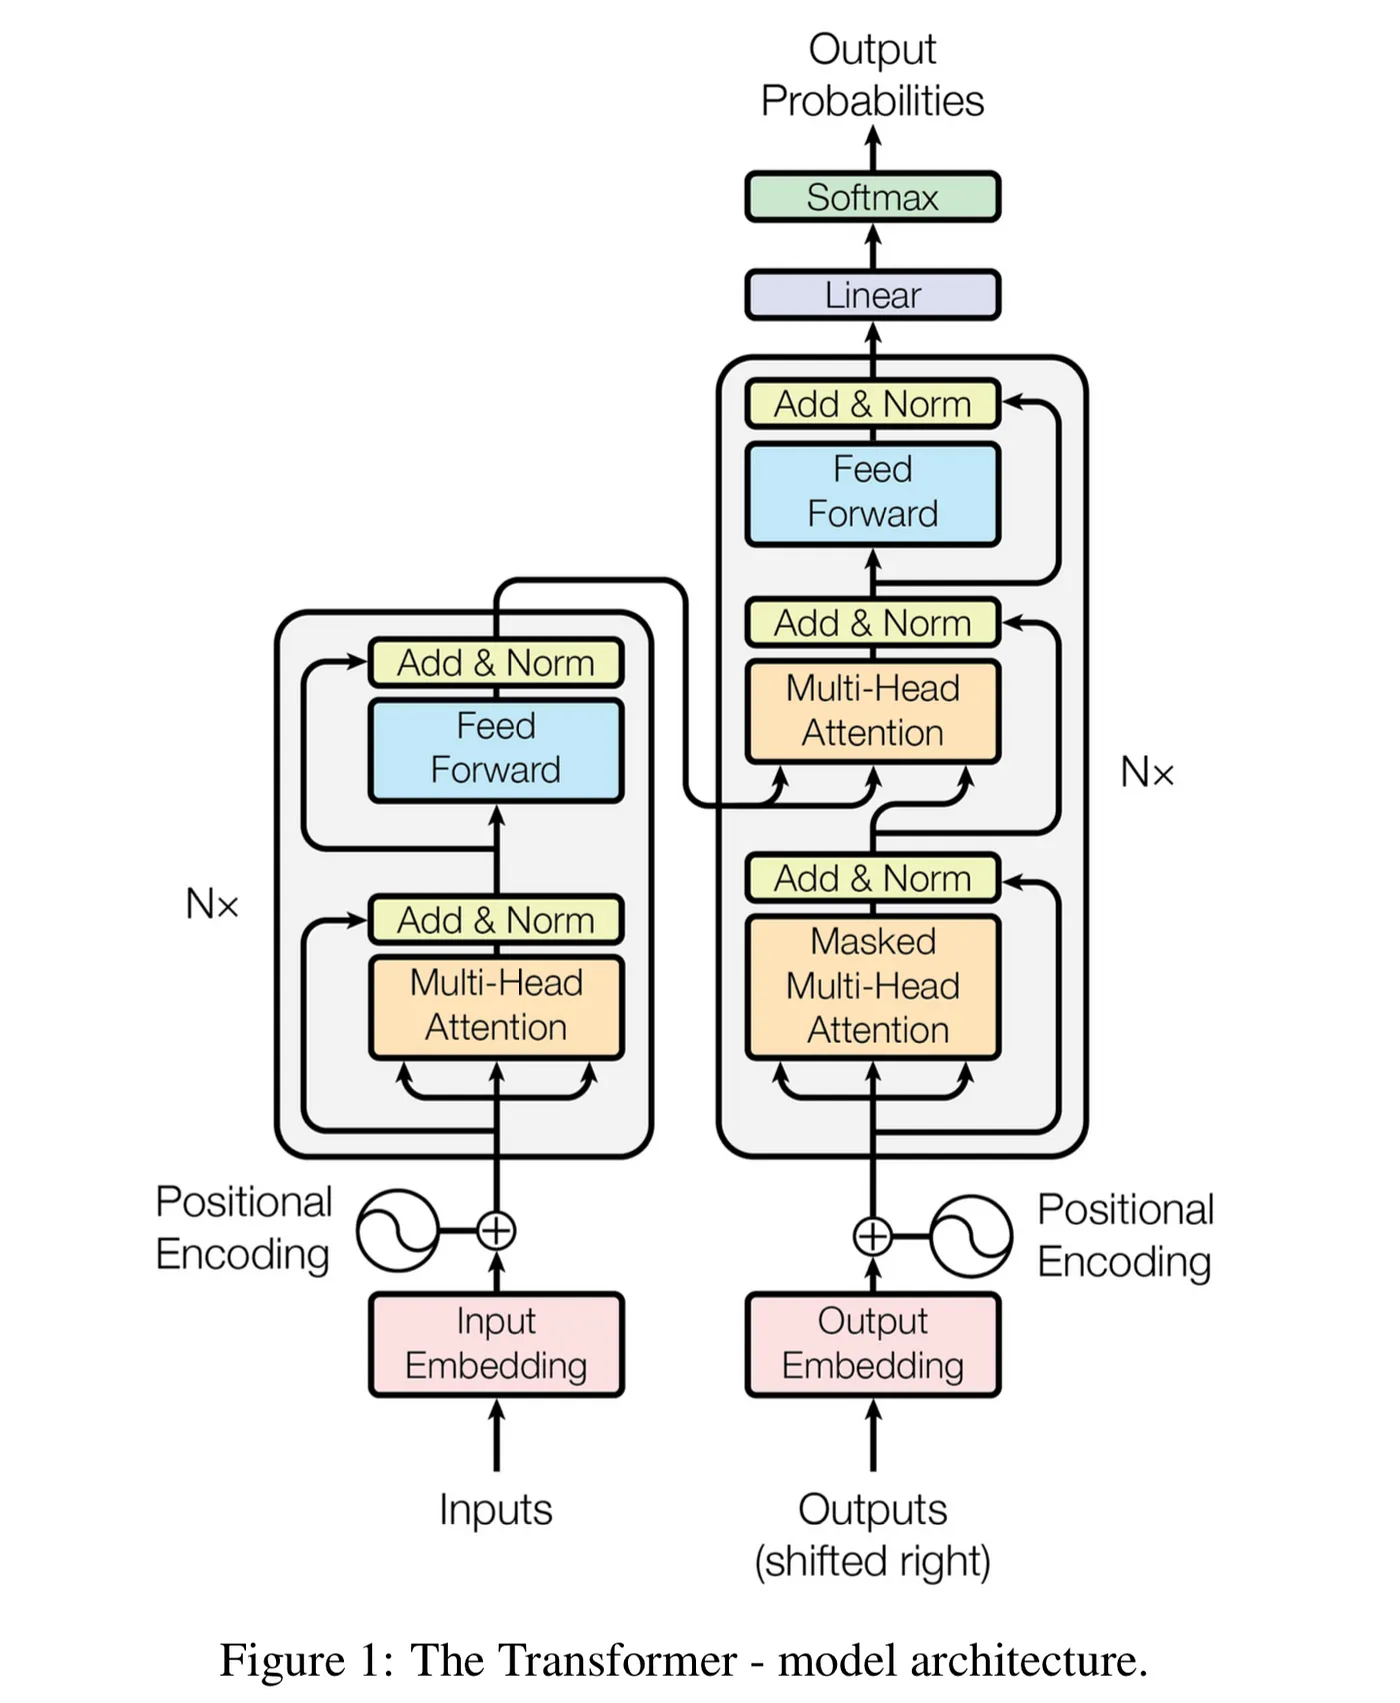

Complétez le code suivant en utilisant les fonctions suivantes:
- *MultiHeadAttention*,
- *Sequential*,
- *Dense*,
- *LayerNormalization*.

Aidez vous de la documentation de TensorFlow


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        ### code start here ###
        self.attention = None
        self.dense_proj = None
        self.layernorm_1 = None
        self.layernorm_2 = None
        ### code end here ###
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        ### code start here ###
        attention_output = None
        proj_input = None
        proj_output = None
        return None
        ### code end here ###

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

Complétez le code suivant en utilisant les fonctions suivantes:
- *Embedding*

Aidez vous de la documentation de TensorFlow


In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        ### code start here ###
        self.token_embeddings = None
        self.position_embeddings = None
        ### code end here ###
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        ### code start here ###
        embedded_tokens = None
        embedded_positions = None
        return None
        ### code end here ###

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Complétez le code suivant en utilisant les fonctions suivantes:
- *MultiHeadAttention*,
- *Sequential*,
- *Dense*,
- *LayerNormalization*.

Aidez vous de la documentation de TensorFlow

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        ### code start here ###
        self.attention_1 =  None
        self.attention_2 = None
        self.dense_proj = None
        self.layernorm_1 = None
        self.layernorm_2 = None
        self.layernorm_3 = None
        ### code end here ###
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        ### code start here ###
        attention_output_1 = None
        out_1 = None
        attention_output_2 = None
        out_2 = None
        proj_output = None
        return None
        ### code end here ###

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

La séquence source sera transmise au `TransformerEncoder`, qui en produira une nouvelle représentation.

Cette nouvelle représentation sera ensuite transmise au `TransformerDecoder`, avec la séquence cible jusqu'à présent (mots cibles 0 à N). Le `TransformerDecoder` cherchera alors à prédire les prochains mots de la séquence cible (N+1 et au-delà).

Un détail clé qui rend cela possible est le masquage causal
(voir la méthode `get_causal_attention_mask()` du `TransformerDecoder`). Le `TransformerDecoder` voit les séquences entières en une seule fois, et nous devons donc nous assurer qu'il n'utilise que les informations des jetons cibles 0 à N lorsqu'il prédit le jeton N+1 (sinon, il pourrait utiliser des informations du futur, ce qui résulterait en un modèle qui ne pourrait pas être utilisé au moment de l'inférence).

Ensuite, nous assemblons le modèle de bout en bout.

In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## Entraîner notre modèle

Nous utiliserons la précision comme moyen rapide de suivre les progrès de la formation sur les données de validation. Notez que la traduction automatique utilise généralement les scores BLEU ainsi que d'autres métriques, plutôt que la précision.

Ici, nous ne nous entraînons que pendant une période, mais pour que le modèle converge réellement, il faut s'entraîner pendant au moins 30 périodes.

Utilisez la méthode *summary* pour visualisez l'architecture global de votre modèle.

In [ ]:
None

Utilisez la méthode *compile* pour compiler votre modèle.

In [ ]:
None

Utilisez la méthode *fit* pour entraîner votre modèle

In [ ]:
epochs = 1 # This should be at least 30 for convergence

None

## Décodage des phrases de test

Enfin, montrons comment traduire de nouvelles phrases anglaises. Nous introduisons simplement dans le modèle la phrase anglaise vectorisée ainsi que le token cible `"[start]"`, puis nous générons de manière répétée le token suivant, jusqu'à ce que nous atteignions le token `"[end]"`. jusqu'à ce que nous atteignions le token `"[end]"`.

In [ ]:
fra_vocab = fra_vectorization.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fra_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = fra_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

Après 30 époques, nous obtenons les résultats suivants :

> She handed him the money.
> [start] ella le pasó el dinero [end]

> Tom has never heard Mary sing.
> [start] tom nunca ha oído cantar a mary [end]

> Perhaps she will come tomorrow.
> [start] tal vez ella vendrá mañana [end]

> I love to write.
> [start] me encanta escribir [end]

> His French is improving little by little.
> [start] su francés va a [UNK] sólo un poco [end]

> My hotel told me to call you.
> [start] mi hotel me dijo que te [UNK] [end]

In [ ]:
decode_sequence("She handed him the money")

In [ ]:
decode_sequence("Tom has never heard Mary sing")

In [ ]:
decode_sequence("Perhaps she will come tomorrow.")

In [ ]:
decode_sequence("I love to write.")

In [ ]:
decode_sequence("His French is improving little by little.")

In [ ]:
decode_sequence("My hotel told me to call you. ")